# SNN with hierarchy of Time constant
---
This notebook is mainly for developing the code that will be rewritten in python files\\

The idea is to explore what role a hierarchy of time scales have in temporal processing, especially when dealing with multi-time-scale inputs.\\

Prior literature shows the importance of heterogeneity of time scales in SNNs, mainly showing that diversity of time-scales are beneficial.
- https://www.nature.com/articles/s41467-021-26022-3
- https://www.nature.com/articles/s41467-023-44614-z

However, an interpretation of the role of the hierarchy of time constant is still missing.

The assumption is that when treating a temporal sequence sempled at a certain period $\tau_{sampling}$ and with a total duration $\Tau$, there can be an optimal sequence of filters $F_i(\tau_i)$ that process the input sequence. For each of the filters $\tau_{i+1} > \tau_i$, where the subscript indicates the order of the filter. More simply, there is a hierarchy of time-scales - from fast to slow - that leads to an optimal processing of the input sequence.

In [1]:
import jax
import jax.numpy as jnp
from jax.example_libraries import optimizers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import random

from jax import vmap, pmap, jit, value_and_grad, local_device_count
from jax.example_libraries import optimizers
from jax.lax import scan, cond
import pickle

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75" # needed because network is huge
os.environ["CUDA_VISIBLE_DEVICES"]="0"
jax.devices()

I0000 00:00:1710106813.757494       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0)]

## Parameters of the SNN model
---

In [2]:
from utils_initialization import args

## Download and Import the SHD dataset
---

In [3]:
from utils_dataset import get_dataloader
train_loader_custom_collate, val_loader_custom_collate, test_loader_custom_collate = get_dataloader( args=args, verbose=True )

Train DL size: 8156, Validation DL size: 1632, Test DL size: 2264


## Neuron Model
---
We'll use Leaky-Integrate-and-Fire neurons for the Hidden layers, Leaky-Integrator neurons for the output.

We also define some additional functions to: Introduce Noise in Weights and Membrane voltage, Introduce the Surrogate Gradient function.

In [4]:
from models import *
from utils_initialization import *

In [5]:
# Normalization Layers
from typing import (Any, Callable, Iterable, Optional, Tuple, Union)

PRNGKey = Any
Array = Any
Shape = Tuple[int, ...]
Dtype = Any  # this could be a real type?

Axes = Union[int, Iterable[int]]

def _canonicalize_axes(rank: int, axes: Axes) -> Tuple[int, ...]:
    """Returns a tuple of deduplicated, sorted, and positive axes."""
    if not isinstance(axes, Iterable):
        axes = (axes,)
    return tuple(set([rank + axis if axis < 0 else axis for axis in axes]))


def _abs_sq(x):
    """Computes the elementwise square of the absolute value |x|^2."""
    if jnp.iscomplexobj(x):
        return jax.lax.square(jax.lax.real(x)) + jax.lax.square(jax.lax.imag(x))
    else:
        return jax.lax.square(x)

def _compute_stats(x: Array, axes: Axes,
                   dtype: Optional[Dtype],
                   axis_name: Optional[str] = None,
                   axis_index_groups: Any = None):
    """Computes mean and variance statistics.
    Returns:
      A pair ``(mean, var)``.
    """
    if dtype is None:
      dtype = jnp.result_type(x)
    # promote x to at least float32, this avoids half precision computation
    # but preserves double or complex floating points
    dtype = jnp.promote_types(dtype, jnp.float32)
    x = jnp.asarray(x, dtype)

    mean = jnp.mean(x, axes)
    mean2 = jnp.mean(_abs_sq(x), axes)
    if axis_name is not None:
      concatenated_mean = jnp.concatenate([mean, mean2])
      mean, mean2 = jnp.split(
          jax.lax.pmean(
              concatenated_mean,
              axis_name=axis_name,
              axis_index_groups=axis_index_groups), 2)
    # mean2 - _abs_sq(mean) is not guaranteed to be non-negative due
    # to floating point round-off errors.
    var = jnp.maximum(0., mean2 - _abs_sq(mean))
    return mean, var


def _normalize(x: Array, mean: Array, var: Array,
               reduction_axes: Axes, feature_axes: Axes,
               dtype: Dtype, param_dtype: Dtype,
               epsilon: float,
               bias: Array,
               scale: Array):
    """"Normalizes the input of a normalization layer and optionally applies a learned scale and bias.

    Arguments:
    mdl: Module to apply the normalization in (normalization params will reside
        in this module).
    x: The input.
    mean: Mean to use for normalization.
    var: Variance to use for normalization.
    reduction_axes: The axes in ``x`` to reduce.
    feature_axes: Axes containing features. A separate bias and scale is learned
        for each specified feature.
    dtype: The dtype of the result (default: infer from input and params).
    param_dtype: The dtype of the parameters.
    epsilon: Normalization epsilon.
    use_bias: If true, add a bias term to the output.
    use_scale: If true, scale the output.
    bias_init: Initialization function for the bias term.
    scale_init: Initialization function for the scaling function.

    Returns:
    The normalized input.
    """
    reduction_axes = _canonicalize_axes(x.ndim, reduction_axes)
    feature_axes = _canonicalize_axes(x.ndim, feature_axes)
    stats_shape = list(x.shape)
    for axis in reduction_axes:
        stats_shape[axis] = 1
    mean = mean.reshape(stats_shape)
    var = var.reshape(stats_shape)
    feature_shape = [1] * x.ndim
    reduced_feature_shape = []
    for ax in feature_axes:
        feature_shape[ax] = x.shape[ax]
        reduced_feature_shape.append(x.shape[ax])
    y = x - mean
    mul = jax.lax.rsqrt(var + epsilon)
    args = [x]
    # scale = mdl.param('scale', scale_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    mul *= scale
    args.append(scale)
    y *= mul
    # bias = mdl.param('bias', bias_init, reduced_feature_shape,
    #                     param_dtype).reshape(feature_shape)
    y += bias
    args.append(bias)
    #   dtype = canonicalize_dtype(*args, dtype=dtype)
    return jnp.asarray(y)

In [6]:
###################
## NORMALIZATION ##
###################
from utils_normalization import *

key = jax.random.PRNGKey(seed=args.seed)
x = jax.random.normal( key, [128,4], dtype=jnp.float32 ) + 10
mean, var = _compute_stats(x, axes=-1, dtype=jnp.float32)
# print( mean, var )

y = _normalize(x, mean, var,
               reduction_axes = -1, feature_axes = -1,
               dtype= jnp.float32, param_dtype = jnp.float32,
               epsilon = 1e-6,
               bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ))
# print( jnp.mean(y, axis=-1), jnp.var(y, axis=-1) )
print( jnp.mean(y), jnp.var(y) )

ynorm = LayerNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(ynorm, axis=-1), jnp.var(ynorm, axis=-1) )
print( jnp.mean(ynorm), jnp.var(ynorm) )

yBnorm = BatchNorm( x, bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(yBnorm), jnp.var(yBnorm) )
print( jnp.mean(yBnorm, axis=0), jnp.var(yBnorm, axis=0) )

-2.8056093e-08 0.99999845
-2.8056093e-08 0.99999845
[-2.7939677e-08 -7.0594251e-07 -1.0058284e-07  4.4703484e-07] [0.9999905  0.99999565 0.99999285 0.99998647]


In [7]:
import torch
xtorch = torch.from_numpy( np.array(x) ).type(torch.float32)

BN = torch.nn.BatchNorm1d( num_features=x.shape[1], track_running_stats=False, dtype=torch.float32 )
yBnorm_torch = BN( xtorch )
print( torch.mean(yBnorm_torch, axis=(0)), torch.var(yBnorm_torch, axis=0) )

tensor([ 3.6508e-07, -5.5879e-08,  7.4506e-08,  2.5332e-07],
       grad_fn=<MeanBackward1>) tensor([1.0079, 1.0079, 1.0079, 1.0079], grad_fn=<VarBackward0>)


In [20]:
x = jax.random.normal( key, [128,100,4], dtype=jnp.float32 ) + 10

### JAX
yBnorm = BatchNorm( x.reshape(128*100, 4), bias = jnp.zeros( (x.shape[-1]) ),
               scale = jnp.ones( (x.shape[-1]) ) )
# print( jnp.mean(yBnorm), jnp.var(yBnorm) )
print( jnp.mean(yBnorm.reshape(128,100,4), axis=(0,1)), jnp.var(yBnorm.reshape(128,100,4), axis=(0,1)) )

import torch
xtorch = torch.from_numpy( np.array(x) ).type(torch.float32)

### PYTORCH
BN = torch.nn.BatchNorm1d( num_features=xtorch.shape[-1], track_running_stats=False, dtype=torch.float32 )
yBnorm_torch = BN( xtorch.reshape(128*100, 4) )
print( torch.mean(yBnorm_torch.reshape(128,100,4), axis=(0,1)), torch.var(yBnorm_torch.reshape(128,100,4), axis=(0,1)) )

[3.3885240e-07 2.0727515e-07 5.1595271e-07 3.8176773e-07] [0.99998546 0.9999844  0.9999723  1.0000018 ]
tensor([ 1.0864e-06,  2.0190e-06,  6.0201e-08, -9.3728e-07],
       grad_fn=<MeanBackward1>) tensor([1.0001, 1.0001, 1.0001, 1.0001], grad_fn=<VarBackward0>)


In [5]:
def lif_step( args_in, input_spikes ):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # V_mem = (alpha) * (V_mem - out_spikes) + (1-alpha) * I_in #- out_spikes*v_thr
    # V_mem = (alpha) * (V_mem - out_spikes) + I_in #- out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes - out_spikes*v_thr
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes


# Leaky Integrate and Fire layer, Recurrent
def rlif_step( args_in, input_spikes):
    ''' Forward function for the Leaky-Integrate and Fire neuron layer, adopted here for the hidden layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states
    win_mask, wrec_mask = w_mask
    if len(w) == 3: # it means that we'll do normalization
        weight, scale, bias = w
    else: weight = w
    win, wrec = weight
    w_rec_diag_zeros = jnp.ones_like(wrec) - jnp.eye( wrec.shape[0] )

    # we evolve the state of the neuron according to the LIF formula, Euler approximation
    I_rec = jnp.matmul(out_spikes, wrec*wrec_mask*w_rec_diag_zeros)
    # V_mem = (alpha) * (V_mem) + (1-alpha) * I_in - out_spikes*v_thr
    V_mem = alpha * V_mem + input_spikes + I_rec - out_spikes*v_thr
    # V_mem = alpha * (V_mem - out_spikes) + (1-alpha) * ( I_in_norm )
    # V_mem = alpha * (V_mem - out_spikes) + (1) * ( I_in_norm )
    out_spikes = spiking_fn( V_mem, v_thr )
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], out_spikes

# Leaky Integrator (output layer)
def li_step(args_in, input_spikes):
    ''' Forward function for the Leaky-Integrator neuron layer, adopted here for the output layers. '''
    net_params, net_states = args_in
    # state: the parameters (weights) and the state of the neurons (inputs and membrane)
    w, alpha = net_params; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states

    # we evolve the state of the neuron according to the LI formula, Euler approximation
    V_mem = (alpha) * (V_mem) + (1-alpha) * input_spikes
    # V_mem = (alpha) * (V_mem) + input_spikes
    
    return [ [w, alpha], [w_mask, tau, V_mem, out_spikes, v_thr, noise_sd] ], V_mem

# parallelizing the Single Layer
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer = vmap( scan_layer, in_axes=(None, 0))

@jit
def scan_out_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer_out, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
vscan_layer_out = vmap( scan_out_layer, in_axes=(None, 0))

@jit
def hsnn( args_in, input_spikes ):
    net_params, net_states, key, dropout_rate = args_in
    n_layers = len( net_params )
    # collection of output spikes
    out_spike_net = []
    # Loop over the layers
    for l in range(n_layers):
        if l == 0: layer_input_spike = input_spikes
        else: layer_input_spike = out_spikes_layer
        # making layers' params and states explitic
        # parameters (weights and alpha) and the state of the neurons (spikes, inputs and membrane, ecc..)
        w, alpha = net_params[l]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[l]
        if len(w) == 3: # it means that we'll do normalization
            weight, scale, bias = w
        else: weight = w
        if len(weight) ==2: weight, _ = weight
        # we evolve the state of the neuron according to the LIF formula, Euler approximation
        I_in = jnp.matmul(layer_input_spike, weight)
        # Normalization (if selected)
        if len(w) == 3: # it means that we'll do normalization
            b, t, n = I_in.shape
            I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
            I_in = I_in.reshape( b,t,n ) # normalized input current
        # Forward pass of the Layer
        args_in = [net_params[l], net_states[l]]
        if l+1 == n_layers:
            _, out_spikes_layer = vscan_layer_out( args_in, I_in )
        else: 
            _, out_spikes_layer = vscan_layer( args_in, I_in )
            # Dropout
            key, key_dropout = jax.random.split(key, 2)
            out_spikes_layer = dropout( key_dropout, out_spikes_layer, rate=dropout_rate, deterministic=False )
        out_spike_net.append(out_spikes_layer)
    return out_spikes_layer, out_spike_net


In [22]:
### try and do a forward pass
key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( train_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = True
args.hierarchy_tau = False
args.recurrent = True
args.normalizer = 'batch' #'layer'
args.norm_bias_init = 0.
args.n_layers = 3
if args.recurrent:
    layer = rlif_step
    # model = hrsnn
else:
    layer = lif_step
    # model = hsnn
layer_out = lif_step
norm = BatchNorm
args.w_scale = [0.3]
net_params, net_states = params_initializer( key, args )

###################################################################################################
#################################      EVOLUTION OF THE LAYER     #################################
###################################################################################################
input_spikes = x_test
# state: the parameters (weights) and the state of the neurons (spikes, inputs and membrane, ecc..)
w, alpha = net_params[0]; w_mask, tau, V_mem, out_spikes, v_thr, noise_sd = net_states[0]
if len(w) == 3: # it means that we'll do normalization
    weight, scale, bias = w
else: weight = w
if len(weight) == 2: weight, _ = weight

# we evolve the state of the neuron according to the LIF formula, Euler approximation
I_in = jnp.matmul(input_spikes, weight)
# normalize inputs
if len(w) == 3: 
    b, t, n = I_in.shape
    I_in = norm( I_in.reshape( b*t, n ), bias = bias, scale = scale )
    I_in = I_in.reshape( b,t,n )
else: I_in = I_in

# Single step
args_in = [net_params[0], net_states[0]]
args_out_step, out_spikes_step = layer( args_in, I_in[0,0] )

# Single Layer
args_in = [net_params[0], net_states[0]]
args_out_layer, out_spikes_layer = scan( layer, args_in, I_in[0], length=args.nb_steps )

# parallelizing the Single Layer
@jit
def scan_layer( args_in, input_spikes ):
    args_out_layer, out_spikes_layer = scan( layer, args_in, input_spikes, length=args.nb_steps )
    return args_out_layer, out_spikes_layer
args_in = [net_params[0], net_states[0]]
vscan_layer = vmap( scan_layer, in_axes=(None, 0))
args_out_vlayer, out_spikes_vlayer = vscan_layer( args_in, I_in )

# Forward pass throught the whole model
args_in = [net_params, net_states, key, dropout_rate]
out_spikes_layer, out_spike_net = hsnn( args_in, input_spikes )

Input shape: train (128, 100, 700) - test (128, 100, 700)


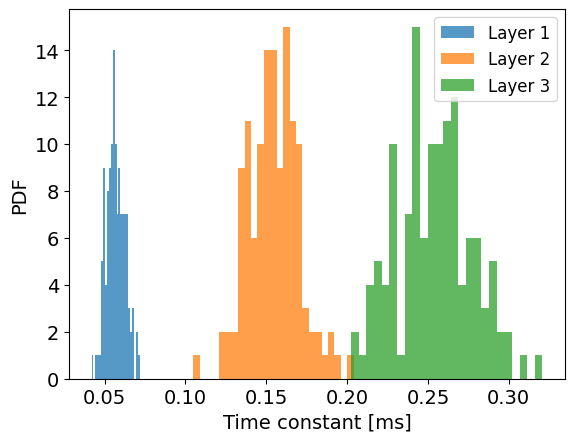

In [8]:
fig, ax = plt.subplots( )
for n in range(len(net_params)):
    if len(net_params[n][1].shape)>0:
        _ = ax.hist(-args.timestep/ np.log(net_params[n][1]), 25, alpha=0.75, label='Layer '+str(n+1))
ax.set_xlabel( 'Time constant [ms]', size=14 )
ax.set_ylabel( 'PDF', size=14 )
ax.tick_params( labelsize=14 )
ax.legend( prop={'size':12} )

# Training Loop
---

In [21]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states, key, dropout_rate = args_in
    _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # forward pass
    net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], X)
    # out_v_mem = net_states_hist[-1][2]
    out_v_mem = net_states_hist[-1][3][:,-1]
    # Yhat = decoder_cum( out_v_mem )
    Yhat = jax.nn.softmax( out_v_mem, axis=-1 )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    # cross entropy loss
    loss_ce = -jnp.sum( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    ################# ----> Do I need the spiking frequency regularizer?
    # reg_quiet = F.relu(self.reg_fmin - firing_rates).sum()
    # reg_burst = F.relu(firing_rates - self.reg_fmax).sum()
    # loss_fr += self.reg_factor * (reg_quiet + reg_burst)
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = False
args.hierarchy_tau = False
args.recurrent = False
args.normalizer = 'none' #'layer'
args.l2_lambda = 0.
args.freq_lambda = 0.
if args.recurrent:
    layer = lif_recurrent
    model = hrsnn_step
    args.w_scale = [0.075, 0.05]
else:
    layer = lif_forward
    model = hsnn_step
    args.w_scale = [0.075]
norm = BatchNorm
args.n_layers = 2


key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

net_params, net_states = params_initializer( key, args )

dropout_rate = 0.0
# testing the training function
args_ins = [net_params, net_states, key, dropout_rate]
args_out = scan(model, args_ins, x_train[0], length=args.nb_steps)
[net_params_hist, net_states_hist] = args_out

net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], x_train )
out_v_mem = net_states_hist[-1][2]

# decoder
Yhat = jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )
Yhat_vmax = jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )
Yhat_cum = jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)
print( Yhat_cum.shape )

# loss
loss_total, loss_values = loss(key, net_params, net_states, x_train, one_hot(Y, 20), 0)

# values and gradients
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, x_test, one_hot(Y_test,20), 0, dropout_rate=0.0)

Input shape: train (128, 100, 700) - test (128, 100, 700)
(128, 20)


In [14]:
net_states_hist[-1][3].shape

(128, 100, 20)

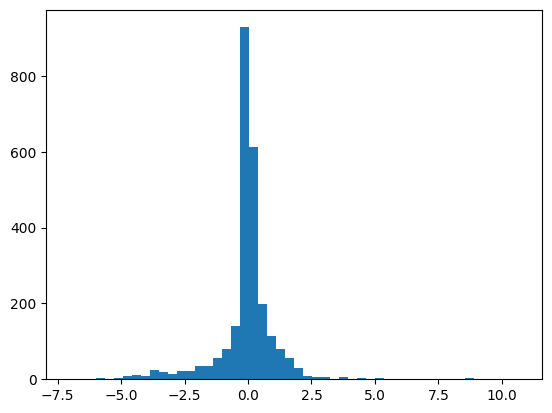

In [17]:
_ = plt.hist( grads[-1][0].flatten(), 50 )

In [18]:
Y_test

array([10, 11,  7, 10,  3,  5,  0, 10, 18,  5, 16, 14, 12,  8,  0, 16, 10,
       16, 17, 13, 19,  9,  7,  4,  6,  9,  0,  0,  9,  9,  6,  2,  3, 12,
        8,  8,  7, 10, 12, 10, 14,  8,  6,  0, 11,  8,  7, 17,  5,  7, 13,
       11, 18,  6, 11,  6, 15, 17, 14,  0,  1, 18, 17, 13,  0, 18, 13,  5,
       14,  1, 10, 13, 14, 14, 10, 11,  4,  3,  7, 17,  8,  7, 14, 14,  7,
       16,  3, 14, 15,  5, 19, 10, 16,  8, 19,  0, 19,  1,  6,  1, 18, 18,
       13, 11, 14, 13,  4, 11,  1, 10,  6, 13,  4,  0,  2, 12, 11, 10, 18,
        4,  1, 12, 12,  0,  4, 17, 13, 16])

In [19]:
for i in range( len(grads) ):
    print( jnp.mean( grads[i][0] ), jnp.std( grads[i][0] ) )

0.012933828 0.20086268
-2.0012523e-09 1.3349917


In [20]:
for i in range( len(grads) ):
    print( jnp.mean( grads[i][1] ), jnp.std( grads[i][1] ) )

3.2256565 0.0
-0.048432942 0.0


In [142]:
jnp.mean( net_states_hist[0][3], axis=(0,1,2) ), jnp.mean( net_states_hist[1][3], axis=(0,1,2) )

(Array(0.09717713, dtype=float32), Array(0.14765441, dtype=float32))

In [69]:
def train_hsnn(key, n_epochs, args, train_dl, test_dl, val_dl, param_initializer, decoder, 
                noise_start_step, noise_std, dataset_name, verbose=True):
    
    key, key_model = jax.random.split(key, 2)

    def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.0):
        """ Calculates CE loss after predictions. """

        # we might want to add noise in the forward pass --> memristor-aware-training
        # weight = [net_params[i][0] for i in range( len(net_params) )]
        # weight = cond(
        #     epoch >= noise_start_step, 
        #     lambda weight, key : add_noise(weight, key, noise_std),
        #     lambda weight, key : weight,
        #     weight, key
        # )
        # Forward pass throught the whole model
        args_in = [net_params, net_states, key, dropout_rate]
        output_layer, out_spike_net = hsnn( args_in, X )
        Yhat = decoder( output_layer )
        # Yhat = jax.nn.softmax( net_states_hist[-1][3][:,-1] )
        # compute the loss and correct examples
        num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
        # cross entropy loss
        loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
        # L2 norm
        loss_l2 = optimizers.l2_norm( [net_params[l][0] for l in range(len(net_params))] ) * args.l2_lambda
        # firing rate loss
        avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( out_spike_net[l], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
        loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
        # Total loss
        loss_total = loss_ce + loss_l2 + loss_fr
        loss_values = [num_correct, loss_ce]
        return loss_total, loss_values
 
    @jit
    def update(key, epoch, net_states, X, Y, opt_state, dropout_rate=0.):
        train_params = get_params(opt_state)
        # forward pass with gradients
        value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, train_params, net_states, X, Y, epoch, dropout_rate=dropout_rate)
        # possibly disable gradients on alpha and gradient clip
        # for g in range( len( grads )-1 ):
        #     if len(grads[g][0]) == 1:
        #         grads[g][0] = jnp.clip(grads[g][0], -args.grad_clip, args.grad_clip) # weight
        #     if len(grads[g][0]) == 2:
        #         for j in range( len(grads[g][0]) ):
        #             grads[g][0][j] = jnp.clip(grads[g][0][j], -args.grad_clip, args.grad_clip) # weight and recurrent
        #     grads[g][1] = jnp.clip(grads[g][1], -args.grad_clip, args.grad_clip) # alpha
        # grads[-1][0] = jnp.clip(grads[-1][0], -args.grad_clip, args.grad_clip) # weight
        # grads[-1][1] = jnp.clip(grads[-1][1], -args.grad_clip, args.grad_clip) # alpha
        return grads, opt_state, value

    def one_hot(x, n_class):
        return jnp.array(x[:, None] == jnp.arange(n_class), dtype=np.float32)

    def total_correct(net_params, net_states, X, Y):
        args_in = [net_params, net_states, key, 0.]
        output_layer, _ = hsnn( args_in, X )
        Yhat = decoder( output_layer )
        # Yhat = jax.nn.softmax( net_states_hist[-1][3][:,-1] )
        acc = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), Y))
        return acc

    # LR decay
    if args.lr_decay_every < n_epochs:
        lr_decay = jnp.clip( args.lr_decay, 0, 1 )
        intervals = [i*args.lr_decay_every for i in range(int(n_epochs/args.lr_decay_every)-1)]
        lr_values = [args.lr*(lr_decay)**i for i in range(int(n_epochs/args.lr_decay_every))]
        pw_lr = optimizers.piecewise_constant(intervals, lr_values)
    else: pw_lr = optimizers.piecewise_constant([n_epochs], [args.lr, args.lr*jnp.clip( args.lr_decay, 1e-8, 1-1e-8 )])
    # define the optimizer
    opt_init, opt_update, get_params = optimizers.adam(step_size=pw_lr)
    # opt_init, opt_update, get_params = optimizers.sgd(step_size=pw_lr)
    # initialize the parameters (and states)
    net_params, net_states = param_initializer( key_model, args )
    ##############################################################################################
    ##############################################################################################
    ##############################################################################################
    # import pickle
    # # params from sparch
    # params = pickle.load( open( '/Users/filippomoro/Desktop/params_snn_77p_numpy.pkl', 'rb' ) )
    # for i in range( len(net_params) ):
    #     net_params[i][0] = params[f'snn.{i}.W.weight'].T
    #     net_params[i][1] = params[f'alpha{i}']
    ##############################################################################################
    ##############################################################################################
    ##############################################################################################
    opt_state = opt_init(net_params)


    # Training loop
    train_loss = []
    train_step = 0
    best_val_acc = 5.0; net_params_best = net_params
    for epoch in range(n_epochs):
        t = time.time()
        acc = 0; count = 0
        for batch_idx, (x, y) in enumerate(train_dl):
            y = one_hot(y, args.n_out)
            key, key_epoch = jax.random.split(key)
            _, net_states = param_initializer(key=key_epoch, args=args)
            grads, opt_state, (L, [tot_correct, _]) = update(key, epoch, net_states, x, y, opt_state, dropout_rate=args.dropout_rate)
            # possibly remove gradient from alpha
            if not args.train_alpha:
                for g in range(len(grads)): grads[g][1] *= 0
            # else: 
            #     for g in range(len(grads)): grads[g][1] *= 1
            # weight update
            opt_state = opt_update(epoch, grads, opt_state)
            net_params = get_params(opt_state)
            # clip alpha between 0 and 1
            # if args.train_alpha:
            #     # for g in range(len(net_params)): net_params[g][1] = jnp.clip(net_params[g][1], jnp.exp(-1/5), jnp.exp(-1/25))
            #     for g in range(len(net_params)): net_params[g][1] = jnp.clip(net_params[g][1], 0, 1.0)
            # append stats
            train_loss.append(L)
            train_step += 1
            acc += tot_correct
            count += x.shape[0]
        
        ### Training logs
        train_acc = 100*acc/count
        elapsed_time = time.time() - t            
        ### Validation
        acc_val = 0; count_val = 0
        for batch_idx, (x, y) in enumerate(val_dl):
            count_val += x.shape[0]
            acc_val += total_correct(net_params, net_states, x, y)
        val_acc = 100*acc_val/count_val
        # save best model is validation accuracy is improved
        if val_acc >= best_val_acc: 
            net_params_best = net_params
            best_val_acc = val_acc

        if verbose: print(f'Epoch: [{epoch+1}/{n_epochs}] - Loss: {L:.5f} - '
              f' Training acc: {train_acc:.2f} - Validation acc: {val_acc:.2f} - t: {elapsed_time:.2f} sec')
        # if epoch % 50 == 0:
        #     # Save training state
        #     trained_params = optimizers.unpack_optimizer_state(opt_state)
        #     checkpoint_path = os.path.join('checkpoints', "checkpoint.pkl")
        #     with open(checkpoint_path, "wb") as file:
        #         pickle.dump(trained_params, file)

    # Testing Loop
    acc = 0; val_acc = 0; count = 0
    if dataset_name in ['shd', 'all']:
        for batch_idx, (x, y) in enumerate(val_dl):
            key, key_epoch = jax.random.split(key)
            _, net_states = param_initializer(key=key_epoch, args=args)
            count += x.shape[0]
            acc += total_correct(net_params_best, net_states, x, y)
        val_acc = 100*acc/count
        print(f'Validation Accuracy: {val_acc:.2f}')

    acc = 0; test_acc = 0; count = 0
    if dataset_name in ['shd', 'all']:
        key, key_epoch = jax.random.split(key)
        _, net_states = param_initializer(key=key_epoch, args=args)
        for batch_idx, (x, y) in enumerate(test_dl):
            count += x.shape[0]
            acc += total_correct(net_params_best, net_states, x, y)
        test_acc = 100*acc/count
        print(f'Test Accuracy: {test_acc:.2f}')

    return train_loss, test_acc, val_acc, net_params_best

In [74]:
args.train_alpha = False
args.hierarchy_tau = True
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = 'batch' # 'batch' #'layer'
args.norm_bias_init = 0.0
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: 
    model = hrsnn_step
    layer = rlif_step
else: 
    model = hsnn_step
    layer = lif_step
layer_out = li_step
args.n_layers = 4
args.n_hid = 128
# time constants
args.tau_mem = 0.2 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
args.distrib_tau_sd = 0.4
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.2 #0.014*5 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05] #[[3*np.sqrt(1/args.n_in), 2*np.sqrt(1/args.n_hid)], [2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid)], [2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid)] ] #[0.075, 0.05]
else : args.w_scale = [ 1*np.sqrt(1/args.n_in), 1*np.sqrt(1/args.n_hid), 1*np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.01
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 0 # 1e-6
args.freq_lambda = 0 #1e-6
args.dropout_rate = 0.1
n_epochs = 10

train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_hsnn(key = jax.random.PRNGKey(args.seed), n_epochs=n_epochs, args = args, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            param_initializer=params_initializer, decoder=decoder_cum,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=True)

Epoch: [1/10] - Loss: 2.94866 -  Training acc: 6.70 - Validation acc: 10.05 - t: 9.45 sec
Epoch: [2/10] - Loss: 2.95215 -  Training acc: 8.92 - Validation acc: 8.58 - t: 4.70 sec
Epoch: [3/10] - Loss: 2.86949 -  Training acc: 8.25 - Validation acc: 8.70 - t: 4.71 sec
Epoch: [4/10] - Loss: 2.79758 -  Training acc: 8.83 - Validation acc: 9.44 - t: 4.76 sec
Epoch: [5/10] - Loss: 2.82853 -  Training acc: 8.25 - Validation acc: 9.01 - t: 4.71 sec
Epoch: [6/10] - Loss: 2.82970 -  Training acc: 8.61 - Validation acc: 10.05 - t: 4.73 sec
Epoch: [7/10] - Loss: 2.89207 -  Training acc: 9.29 - Validation acc: 8.70 - t: 4.70 sec
Epoch: [8/10] - Loss: 2.84752 -  Training acc: 9.58 - Validation acc: 9.13 - t: 4.75 sec
Epoch: [9/10] - Loss: 2.86662 -  Training acc: 8.94 - Validation acc: 9.01 - t: 4.76 sec
Epoch: [10/10] - Loss: 2.85017 -  Training acc: 9.15 - Validation acc: 8.88 - t: 4.72 sec
Validation Accuracy: 10.05
Test Accuracy: 7.60


0.88971114
0.89265585
0.877461


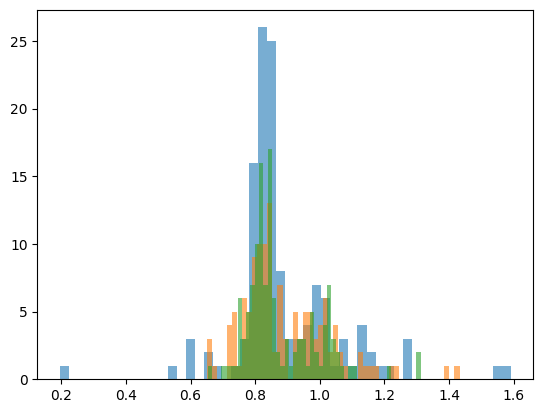

In [71]:
for i in range(args.n_layers-1):
    _ = plt.hist( net_params_trained[i][1], 50, alpha=0.6 )
    print( np.mean(net_params_trained[i][1]) )

In [ ]:
_ = plt.hist( net_params_trained[0][0].flatten(), 50 )
_ = plt.hist( params[f'snn.{0}.W.weight'].T.flatten(), 50, alpha=0.5 )

In [14]:
key = jax.random.PRNGKey(args.seed)
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states = args_in
    _, net_states_hist = scan(hsnn_step, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

# initialize parameters
net_params, net_states = params_initializer( jax.random.PRNGKey(args.seed), args )
acc = 0; count =0
for x_test, Y_test in train_loader_custom_collate :
    net_states_hist = v_predict( [net_params_trained, net_states, key, 0.], x_test)
    out_v_mem = net_states_hist[-1][2]
    Yhat = decoder_vmax( out_v_mem )
    count += x_test.shape[0]
    acc += jnp.sum( (jnp.argmax(Yhat, axis=-1) == Y_test).astype(int) )
acc /= count
print(f'Acc {acc*100}')

Acc 65.94114685058594


In [15]:
jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params_trained)-1 )] ) )

Array(13.328566, dtype=float32)

In [16]:
### try and do a forward pass
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

# initialize parameters
net_params, net_states = params_initializer( key, args )

net_states_hist = v_predict( [net_params_trained, net_states, key, 0.], x_test)
out_v_mem = net_states_hist[-1][2]
Yhat = decoder_vmax( out_v_mem )

Input shape: train (128, 100, 256) - test (128, 100, 256)


In [12]:
import pickle
# params from sparch
params = pickle.load( open( '/Users/filippomoro/Desktop/params_snn_init_numpy.pkl', 'rb' ) )
# initialize my parameters
net_params, net_states = params_initializer( key = jax.random.PRNGKey(args.seed), args=args )

# for i in range( len(net_params) ):
#     net_params[i][0] = params[f'snn.{i}.W.weight'].T
#     net_params[i][1] = params[f'alpha{i}']

In [17]:
params.keys()

dict_keys(['snn.0.W.weight', 'alpha0', 'snn.1.W.weight', 'alpha1', 'snn.2.W.weight', 'alpha2'])

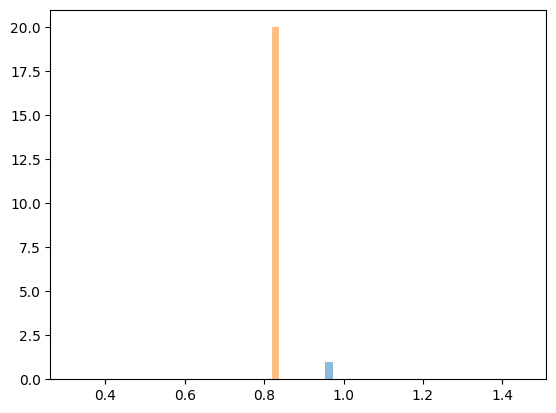

In [23]:
_ = plt.hist( net_params[2][1].flatten(), 50, alpha=0.5 )
_ = plt.hist( params[f'alpha{2}'].flatten(), 50, alpha=0.5 )

In [ ]:
_ = plt.hist( net_params[0][0].flatten(), 50, alpha=0.5 )
_ = plt.hist( params[f'snn.{0}.W.weight'].flatten(), 50, alpha=0.5 )

In [114]:
for i in range( len(net_params) ):
    net_params[i][0] = params[f'snn.{i}.W.weight'].T
    net_params[i][1] = params[f'alpha{i}']
    print( params[f'snn.{i}.W.weight'].T.shape, params[f'alpha{i}'].shape )

(700, 128) (128,)
(128, 128) (128,)
(128, 20) (20,)


In [109]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def total_correct(net_params, net_states, X, Y):
    net_states_hist = v_predict( [net_params, net_states, key, 0.], X) # last value refers to the Dropout rate
    # out_v_mem = net_states_hist[-1][2]
    # Yhat = decoder( out_v_mem )
    Yhat = jax.nn.softmax( net_states_hist[-1][3][:,-1] )
    acc = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), Y))
    return acc

acc = 0; test_acc = 0; count = 0
key = jax.random.PRNGKey(args.seed)
for batch_idx, (x, y) in enumerate(test_loader_custom_collate):
    count += x.shape[0]
    acc += total_correct(net_params, net_states, x, y)
test_acc = 100*acc/count
print(f'Test Accuracy: {test_acc:.5f}')

Test Accuracy: 79.01943


In [80]:
@jit
def predict(args_in, X):
    """ Scans over time and return predictions. """
    # net_params, net_states, key, dropout_rate = args_in
    _, net_states_hist = scan(model, args_in, X, length=args.nb_steps)
    return net_states_hist
# vmap the forward of the model
v_predict = vmap(predict, in_axes=(None, 0))

def one_hot(x, n_class):
    return jnp.array(x[:, None] == jnp.arange(n_class), dtype=jnp.float32)

def loss(key, net_params, net_states, X, Y, epoch, dropout_rate=0.):
    """ Calculates CE loss after predictions. """

    # we might want to add noise in the forward pass --> memristor-aware-training
    # weight = [net_params[i][0] for i in range( len(net_params) )]
    # weight = cond(
    #     epoch >= noise_start_step, 
    #     lambda weight, key : add_noise(weight, key, noise_std),
    #     lambda weight, key : weight,
    #     weight, key
    # )
    # forward pass
    net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], X)
    # out_v_mem = net_states_hist[-1][2]
    out_v_mem = net_states_hist[-1][3][:,-1]
    # Yhat = decoder_cum( out_v_mem )
    Yhat = jax.nn.softmax( out_v_mem, axis=-1 )
    # compute the loss and correct examples
    num_correct = jnp.sum(jnp.equal(jnp.argmax(Yhat, 1), jnp.argmax(Y, 1)))
    # cross entropy loss
    loss_ce = -jnp.mean( jnp.sum(Y * jnp.log(Yhat+1e-12), axis=-1) )
    # L2 norm
    loss_l2 = optimizers.l2_norm( net_params ) * args.l2_lambda
    # firing rate loss
    avg_spikes_neuron = jnp.mean( jnp.stack( [ jnp.mean( jnp.sum( net_states_hist[l][3], axis=1 ), axis=(0,-1) ) for l in range( len(net_params)-1 )] ) )
    loss_fr = args.freq_lambda * (args.target_fr - avg_spikes_neuron)**2
    ################# ----> Do I need the spiking frequency regularizer?
    # reg_quiet = F.relu(self.reg_fmin - firing_rates).sum()
    # reg_burst = F.relu(firing_rates - self.reg_fmax).sum()
    # loss_fr += self.reg_factor * (reg_quiet + reg_burst)
    loss_total = loss_ce + loss_l2 + loss_fr
    loss_values = [num_correct, loss_ce]
    return loss_total, loss_values

# initialize parameters
dropout_rate = 0.0
args.distrib_tau = False
args.hierarchy_tau = False
args.recurrent = False
args.normalizer = 'none' #'layer'
args.l2_lambda = 0.
args.freq_lambda = 0.
if args.recurrent:
    layer = lif_recurrent
    model = hrsnn_step
    args.w_scale = [0.075, 0.05]
else:
    layer = lif_forward
    model = hsnn_step
    args.w_scale = [0.075]
norm = BatchNorm
args.n_layers = 3


key = jax.random.PRNGKey(seed=args.seed)
# load data
x_train, Y = next(iter( train_loader_custom_collate ))
x_test, Y_test = next(iter( test_loader_custom_collate ))
print('Input shape: train '+ str(x_train.shape) + ' - test '+ str(x_test.shape) )

_, net_states = params_initializer( key, args )

dropout_rate = 0.0
# testing the training function
args_ins = [net_params, net_states, key, dropout_rate]
args_out = scan(model, args_ins, x_train[0], length=args.nb_steps)
[net_params_hist, net_states_hist] = args_out

net_states_hist = v_predict( [net_params, net_states, key, dropout_rate], x_test )
out_v_mem = net_states_hist[-1][2]

# decoder
Yhat = jax.nn.softmax( jnp.mean( out_v_mem, axis=1 ), axis=-1 )
Yhat_vmax = jax.nn.softmax( jnp.max( out_v_mem, axis=1 ), axis=-1 )
Yhat_cum = jnp.mean( jax.nn.softmax( out_v_mem, axis=-1 ), axis=1)
print( Yhat_cum.shape )

# loss
loss_total, loss_values = loss(key, net_params, net_states, x_test, one_hot(Y_test, 20), 0)

# values and gradients
value, grads = value_and_grad(loss, has_aux=True, argnums=(1))(key, net_params, net_states, x_test, one_hot(Y_test,20), 0, dropout_rate=0.0)

Input shape: train (128, 100, 700) - test (128, 100, 700)
(128, 20)


In [81]:
net_states_hist[-1][3][:,-1][0]

Array([ 8.276392  ,  8.938479  ,  4.4812484 ,  7.7184925 ,  4.021052  ,
        3.664058  ,  0.6440565 ,  3.4358127 ,  3.5182076 ,  4.907507  ,
       14.740079  ,  1.8497047 ,  1.4626075 ,  4.5900016 ,  6.3239985 ,
        6.5547924 ,  0.8976141 ,  5.580002  ,  0.68965346,  7.7062435 ],      dtype=float32)

In [82]:
for i in range( len(grads) ):
    print( jnp.mean( grads[i][0] ), jnp.std( grads[i][0] ) )

-0.0001136676 0.0027103187
4.9890332e-05 0.009270672
-6.257324e-11 0.024859726


In [70]:
value

(Array(0.711745, dtype=float32),
 [Array(103, dtype=int32), Array(0.711745, dtype=float32)])

In [86]:
grads[-1][0].sum( axis=0 )

Array([-3.662955  , -1.3030419 ,  1.0605583 , -1.0207307 ,  0.713179  ,
        0.02782269,  0.386837  ,  0.23072156,  0.5130479 ,  2.5577378 ,
        1.4432437 ,  1.4370977 , -1.4085054 , -1.7211031 , -1.372419  ,
        0.42121893,  0.44400537,  1.5411721 ,  0.22834672, -0.5162333 ],      dtype=float32)

# Small Hyperparameter Tuning / Early Analysis
---


In [9]:
### Tau FF: Hidden
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = None # 'batch' #'layer'
args.norm_bias_init = 0.3
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.3 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.1 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05]
else : args.w_scale = [ 2*np.sqrt(1/args.n_in), 2*np.sqrt(1/args.n_hid), 2*np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 1e-5
args.freq_lambda = 0 #1e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_mem = tau
    print(f'-- Tau = {tau*1e3}ms')
    train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Tau = 10.0ms
Validation Accuracy: 72.98
Test Accuracy: 61.75
-- Tau = 50.0ms
Validation Accuracy: 78.98
Test Accuracy: 65.33
-- Tau = 100.0ms
Validation Accuracy: 82.23
Test Accuracy: 69.04
-- Tau = 200.0ms
Validation Accuracy: 80.94
Test Accuracy: 67.93
-- Tau = 300.0ms
Validation Accuracy: 86.09
Test Accuracy: 68.02
-- Tau = 500.0ms
Validation Accuracy: 84.80
Test Accuracy: 69.39


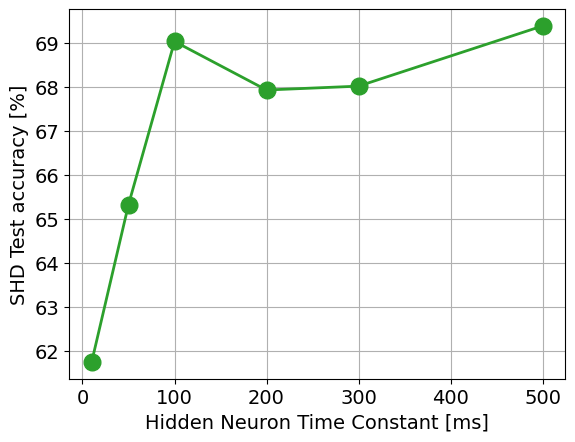

In [10]:
fig, ax = plt.subplots()
tau_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Hidden Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)

In [17]:
### Tau FF: output
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = False
args.recurrent = False
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.25 #0.1
args.tau_out = 0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = 0.1
else : args.w_scale = 0.3
# LR and regularizers
args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 5e-5
args.freq_lambda = 5e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_out = tau
    print(f'-- Tau = {tau*1e3}ms')
    _, test_acc_shd, test_acc_ssc, val_acc_shd, _ = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                    train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                    model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                    noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Tau = 1.0ms
SHD Validation Accuracy: 85.85
SHD Test Accuracy: 68.15
-- Tau = 10.0ms
SHD Validation Accuracy: 84.01
SHD Test Accuracy: 70.67
-- Tau = 50.0ms
SHD Validation Accuracy: 83.33
SHD Test Accuracy: 64.58
-- Tau = 100.0ms
SHD Validation Accuracy: 68.69
SHD Test Accuracy: 60.69
-- Tau = 250.0ms
SHD Validation Accuracy: 38.42
SHD Test Accuracy: 35.78


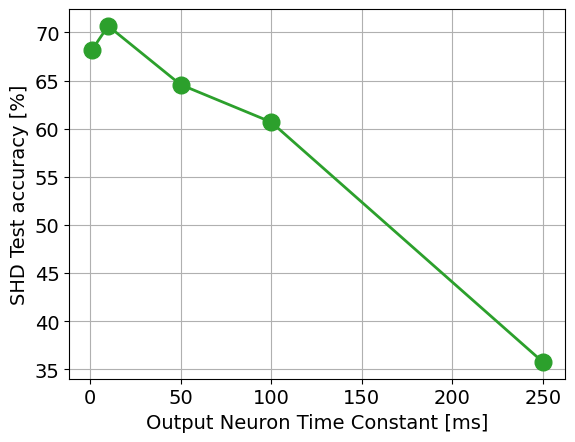

In [18]:
fig, ax = plt.subplots()
tau_list = [0.001, 0.01, 0.05, 0.1, 0.25]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Output Neuron Time Constant [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)

In [13]:
# Effect of Tau FF Hierarchy

### Tau FF: Hidden
args.train_alpha = False
args.hierarchy_tau = False
args.distrib_tau = True
args.distrib_tau_bittar = False
args.recurrent = False
args.normalizer = None # 'batch' #'layer'
args.norm_bias_init = 0.3
if args.normalizer == 'batch': norm = BatchNorm
elif args.normalizer == 'layer': norm = LayerNorm
else: norm = None
# network architecture
if args.recurrent: model = hrsnn_step
else: model = hsnn_step
args.n_layers = 3
args.n_hid = 128
# time constants
args.tau_mem = 0.1 #0.1
delta_tau = 0.1
args.tau_end = args.tau_mem + delta_tau
args.tau_start = args.tau_mem - delta_tau
if args.recurrent: args.tau_out = 0.1
else: args.tau_out = 0.1 # 0.21 #0.01
# weight init
### 0.3 for FF, 0.1 for Rec
if args.recurrent: args.w_scale = [0.075, 0.05]
else : args.w_scale = [ np.sqrt(1/args.n_in), np.sqrt(1/args.n_hid), np.sqrt(1/args.n_hid) ] #[0.3]*args.n_layers
# LR and regularizers
if args.recurrent: args.lr = 0.001
else: args.lr = 0.01
args.lr_decay = 0.5
args.lr_decay_every = 50
args.l2_lambda = 1e-5
args.freq_lambda = 0 #1e-5
args.dropout_rate = 0.1
n_epochs = 50

tau_list = [0.01, 0.05, 0.1, 0.2]
test_acc_shd_list, val_acc_shd_list = [], []
for t, tau in enumerate( tau_list ):
    args.tau_end = args.tau_mem + tau
    args.tau_start = args.tau_mem - tau
    print(f'-- Delta Tau = {tau*1e3}ms')
    train_loss, test_acc_shd, val_acc_shd, net_params_trained = train_mosaic(key = jax.random.PRNGKey(args.seed), n_batch=args.batch_size, n_epochs=n_epochs, args = args, lr = args.lr, 
                                                            train_dl = train_loader_custom_collate, test_dl = test_loader_custom_collate, val_dl=val_loader_custom_collate,
                                                            model=model, param_initializer=params_initializer, decoder=decoder_sum,
                                                            noise_start_step=10, noise_std=0.1, dataset_name='shd', verbose=False)
    test_acc_shd_list.append( test_acc_shd ), val_acc_shd_list.append( val_acc_shd )
    

-- Delta Tau = 10.0ms
Validation Accuracy: 84.31
Test Accuracy: 68.82
-- Delta Tau = 50.0ms
Validation Accuracy: 83.09
Test Accuracy: 69.52
-- Delta Tau = 100.0ms
Validation Accuracy: 82.05
Test Accuracy: 67.09
-- Delta Tau = 200.0ms
Validation Accuracy: 83.21
Test Accuracy: 70.14


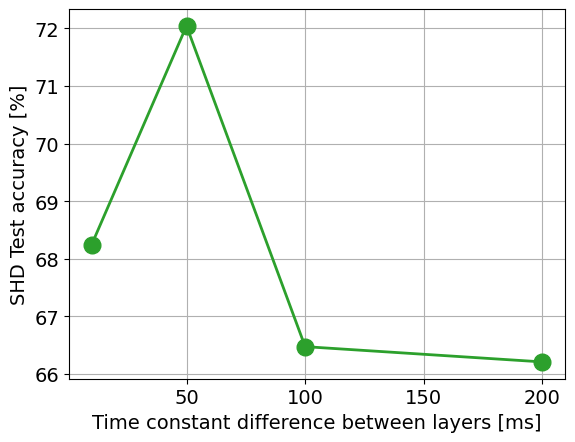

In [12]:
fig, ax = plt.subplots()
tau_list = [0.01, 0.05, 0.1, 0.2]
ax.plot( np.array(tau_list)*1e3, test_acc_shd_list, marker='o', color='tab:green', lw=2, markersize=12 )
ax.set_xlabel( 'Time constant difference between layers [ms]', size=14 )
ax.set_ylabel( 'SHD Test accuracy [%]', size=14 )
ax.tick_params( labelsize=14 )
ax.grid(True)